# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import abc

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Dropout, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, Conv2D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

import cv2
import matplotlib.pyplot as plt
% matplotlib inline

print('Imported')

Using TensorFlow backend.


Imported


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In [3]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
# train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
# val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())

train_doc = np.random.permutation(open('/mnt/disks/user/project/PROJECT/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/mnt/disks/user/project/PROJECT/Project_data/val.csv').readlines())

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
class ModelGenerator():
    
    def __init__(self, num_images_to_use=18, image_height=100, image_width=100, batch=15):
        self.num_images_to_use = num_images_to_use
        self.height = image_height 
        self.width = image_width
        self.batch = batch
        
#         self.train_path = '/notebooks/storage/Final_data/Collated_training/train'
#         self.val_path = '/notebooks/storage/Final_data/Collated_training/val'
        
        self.train_path = '/mnt/disks/user/project/PROJECT/Project_data/train'
        self.val_path = '/mnt/disks/user/project/PROJECT/Project_data/val'

    def __resize_image__(self, image):
        """ Function is used to resize the images """

        if image.shape[1] == 160:
            image = imresize(image[:,20:140,:],(self.height, self.width)).astype(np.float32)
        else:
            image = imresize(image,(self.height, self.width)).astype(np.float32)

        return image
    
    def generate(self):
        
        batch_size = self.batch
        
        train_generator = self.__generator__(self.train_path, train_doc, batch_size)
        val_generator = self.__generator__(self.val_path, val_doc, batch_size)
        
        return train_generator, val_generator
        
    
    def __generator__(self, source_path, folder_list, batch_size):
        print( 'Source path = ', source_path, '; batch size =', batch_size)
        img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
        x = num_images_to_use
        y = self.height
        z = self.width
        batch_size = self.batch
        while True:
            t = np.random.permutation(folder_list)
            num_batches = int(len(t)/batch_size)
            for batch in range(num_batches): # we iterate over the number of batches
                batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes

                        image = self.__resize_image__(image)

                        batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                        batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                        batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


            # write the code for the remaining data points which are left after full batches
            remaining_squences = (len(t) % batch_size)

            if remaining_squences != 0:
                batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output

                for folder in range(remaining_squences):
                    imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                    for idx,item in enumerate(img_idx):
                        image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        image = self.__resize_image__(image)

                        batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                        batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                        batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
class ModelTrainer():
    
    def __init__(self, name, model_generator, model, optimizer, batch=15, epochs=25):
        self.name = name
        self.mg = model_generator
        self.optimizer = optimizer
        self.train_model = model
        self.cbcks = None
        self.batch = batch
        
        self.num_train_sequences = len(train_doc)
        print('# training sequences =', self.num_train_sequences)
        self.num_val_sequences = len(val_doc)
        print('# validation sequences =', self.num_val_sequences)
        self.num_epochs = epochs
        print('# epochs =', self.num_epochs)
        
    
    def __get_checkpoint__(self):
        
        curr_dt_time = datetime.datetime.now()
        model_name = 'model_init_' + self.name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        return ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    
    def __get_early_stop__(self):
        es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', patience=3, verbose=1)
        
        return es
        
    def set_callbacks(self, callbacks):
        self.cbcks = callbacks
        
    def __get_callbacks__(self):
        chkpt = self.__get_checkpoint__()
        es = self.__get_early_stop__()
        
        if self.cbcks is None:
            return [chkpt, es]
        else:
            self.cbcks.append(chkpt)
            self.cbcks.append(es)
            
            return self.cbcks
        
        
    def compile_model(self):
        self.train_model.compile(optimizer=self.optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        print(self.train_model.summary())
        
    def train(self):
        
        if (self.num_train_sequences%self.batch) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch) + 1

        if (self.num_val_sequences%self.batch) == 0:
            validation_steps = int(self.num_val_sequences/self.batch)
        else:
            validation_steps = (self.num_val_sequences//self.batch) + 1
        
        train_generator, val_generator = self.mg.generate()
        
        callbacks = self.__get_callbacks__()
        
        return self.train_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                    callbacks=callbacks, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    
    

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### First sample model

In [7]:

# write your model here
# Creting Conv3D

num_images_to_use=20 
image_height=100
image_width=100

model = Sequential([
    Conv3D(16, (3,3,3), padding='same', input_shape=(num_images_to_use, image_height, image_width, 3)),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2)),
    
    Conv3D(32, (2,2,2), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)),
    
    Conv3D(64, (2,2,2), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)),
           
    Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)),
           
           
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    
    Dense(5, activation='softmax')
])

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [8]:
optimiser = optimizers.Adam(lr=0.001)

mg = ModelGenerator(num_images_to_use=16, image_height=100, image_width=100)
mt = ModelTrainer('conv3d_1', mg, model, optimiser)
mt.compile_model()

# training sequences = 663
# validation sequences = 100
# epochs = 25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 20, 100, 100, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 50, 50, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 50, 50, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 10, 50, 50, 32)    0         
_________________________________________________________________
batch_

In [9]:
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [19]:
model1_history = mt.train()

Source path =  Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 15
/mnt/disks/user/project/PROJECT/Project_data/val ; batch size =Epoch 1/25 15



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


45/45 [==============================] - 139s 3s/step - loss: 1.6996 - categorical_accuracy: 0.3659 - val_loss: 1.3951 - val_categorical_accuracy: 0.3619

Epoch 00001: saving model to model_init_conv3d_1_2021-02-0511_12_06.948919/model-00001-1.69956-0.36593-1.39514-0.36190.h5
Epoch 2/25
45/45 [==============================] - 54s 1s/step - loss: 1.1695 - categorical_accuracy: 0.5289 - val_loss: 1.0626 - val_categorical_accuracy: 0.4286

Epoch 00002: saving model to model_init_conv3d_1_2021-02-0511_12_06.948919/model-00002-1.16946-0.52889-1.06261-0.42857.h5
Epoch 3/25
45/45 [==============================] - 43s 960ms/step - loss: 0.9809 - categorical_accuracy: 0.6044 - val_loss: 0.8831 - val_categorical_accuracy: 0.5143

Epoch 00003: saving model to model_init_conv3d_1_2021-02-0511_12_06.948919/model-00003-0.98092-0.60444-0.88311-0.51429.h5
Epoch 4/25
45/45 [==============================] - 43s 960ms/step - loss: 0.8462 - categorical_accuracy: 0.6267 - val_loss: 1.2019 - val_categori

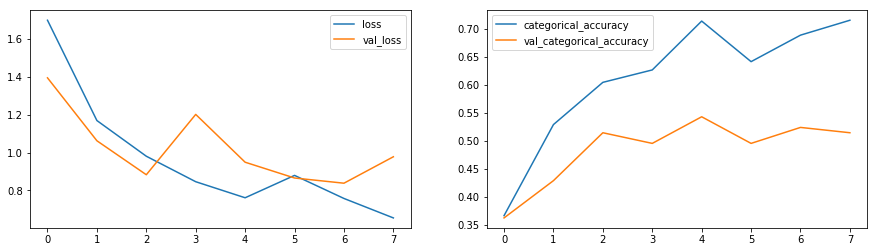

In [20]:
plot(model1_history)

### Playing with the resolution of image

Keeping all other parameters same and changing the resolution of the image used and the number of images used

In [21]:
num_images_to_use = 18
image_height = 160
image_width = 160

model2 = Sequential([
    Conv3D(16, (3,3,3), padding='same', input_shape=(num_images_to_use, image_height, image_width, 3)),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2)),
    
    Conv3D(32, (2,2,2), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)),
    
    Conv3D(64, (2,2,2), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)),
           
    Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)),
           
           
    Flatten(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    
    Dense(5, activation='softmax')
])

In [22]:
optimiser = optimizers.Adam(lr=0.001)

mg = ModelGenerator(num_images_to_use=num_images_to_use, image_height=image_height, image_width=image_width)
mt = ModelTrainer('conv3d_2', mg, model2, optimiser)
mt.compile_model()

# training sequences = 663
# validation sequences = 100
# epochs = 25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 18, 160, 160, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 18, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 18, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 9, 80, 80, 16)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 9, 80, 80, 32)     4128      
_________________________________________________________________
activation_10 (Activation)   (None, 9, 80, 80, 32)     0         
_________________________________________________________________
batch_

In [23]:
model2_history = mt.train()

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 15
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 15
Epoch 1/25


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 6/45 [===>..........................] - ETA: 1:08 - loss: 2.3585 - categorical_accuracy: 0.2111

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


45/45 [==============================] - 60s 1s/step - loss: 1.6083 - categorical_accuracy: 0.3941 - val_loss: 1.1370 - val_categorical_accuracy: 0.4095

Epoch 00001: saving model to model_init_conv3d_2_2021-02-0511_21_35.967371/model-00001-1.60831-0.39407-1.13698-0.40952.h5
Epoch 2/25
45/45 [==============================] - 53s 1s/step - loss: 1.1936 - categorical_accuracy: 0.4874 - val_loss: 0.7797 - val_categorical_accuracy: 0.5714

Epoch 00002: saving model to model_init_conv3d_2_2021-02-0511_21_35.967371/model-00002-1.19363-0.48741-0.77974-0.57143.h5
Epoch 3/25
45/45 [==============================] - 55s 1s/step - loss: 1.0507 - categorical_accuracy: 0.5393 - val_loss: 0.8747 - val_categorical_accuracy: 0.4952

Epoch 00003: saving model to model_init_conv3d_2_2021-02-0511_21_35.967371/model-00003-1.05073-0.53926-0.87474-0.49524.h5
Epoch 4/25
45/45 [==============================] - 55s 1s/step - loss: 0.9108 - categorical_accuracy: 0.6222 - val_loss: 0.7555 - val_categorical_acc

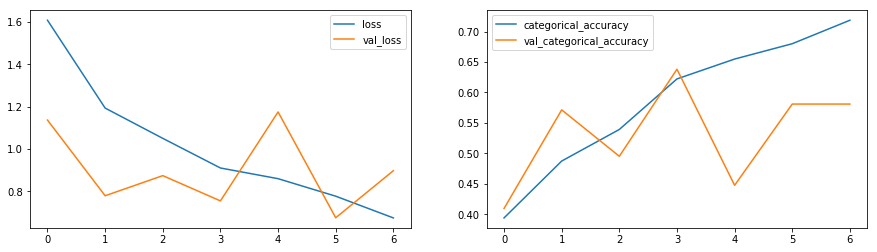

In [24]:
plot(model2_history)

### Changing filter size to = (3,3,3) and increasing the dense neuron size to 256

In [25]:
num_images_to_use = 20
image_height = 160
image_width = 160

model3 = Sequential([
    Conv3D(16, (3,3,3), padding='same', input_shape=(num_images_to_use, image_height, image_width, 3)),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2)),
    
    Conv3D(32, (3,3,3), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2)),
    
#     Dropout(0.25),
    
    Conv3D(64, (3,3,3), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2)),
           
    Conv3D(128, (3,3,3), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2)),
    
    
#     Conv3D(128, (3,3,3), padding='same'),
#     Activation('relu'),
#     BatchNormalization(),
#     MaxPooling3D(pool_size=(2,2,2)),
           
    Flatten(),
    Dense(64, activation='relu'),
    BatchNormalization(),
#     Dropout(0.25),
    
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    
    Dense(5, activation='softmax')
])

In [26]:
batch=20
epoch=20

optimiser = optimizers.SGD(lr=0.001)

mg = ModelGenerator(num_images_to_use=num_images_to_use, image_height=image_height, image_width=image_width, batch=batch)
mt = ModelTrainer('conv3d_3', mg, model3, optimiser, batch=batch, epochs=epoch)
mt.compile_model()

# training sequences = 663
# validation sequences = 100
# epochs = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_14 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_

In [27]:
model3_history = mt.train()

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 20
Source path =  Epoch 1/20
/mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 3s - loss: 1.8236 - categorical_accuracy: 0.3375

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


34/34 [==============================] - 63s 2s/step - loss: 1.7591 - categorical_accuracy: 0.3353 - val_loss: 1.5155 - val_categorical_accuracy: 0.4000

Epoch 00001: saving model to model_init_conv3d_3_2021-02-0512_03_13.203415/model-00001-1.75913-0.33529-1.51548-0.40000.h5
Epoch 2/20
34/34 [==============================] - 53s 2s/step - loss: 1.1495 - categorical_accuracy: 0.5338 - val_loss: 1.4753 - val_categorical_accuracy: 0.4300

Epoch 00002: saving model to model_init_conv3d_3_2021-02-0512_03_13.203415/model-00002-1.14947-0.53382-1.47532-0.43000.h5
Epoch 3/20
34/34 [==============================] - 55s 2s/step - loss: 0.8148 - categorical_accuracy: 0.6588 - val_loss: 1.4419 - val_categorical_accuracy: 0.4900

Epoch 00003: saving model to model_init_conv3d_3_2021-02-0512_03_13.203415/model-00003-0.81481-0.65882-1.44187-0.49000.h5
Epoch 4/20
34/34 [==============================] - 55s 2s/step - loss: 0.6600 - categorical_accuracy: 0.7206 - val_loss: 1.1070 - val_categorical_acc

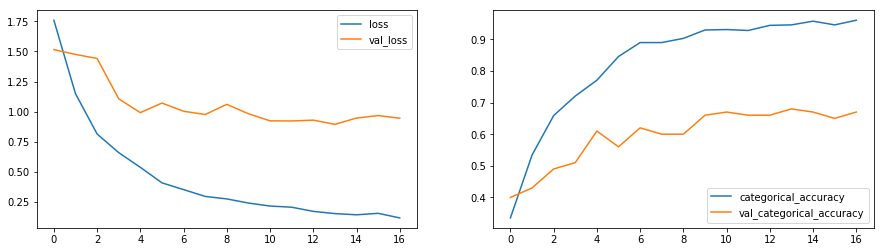

In [29]:
plot(model3_history)

### Increasing the dropout rate

In [12]:

# write your model here
# Creting Conv3D

num_images_to_use=18
image_height=160
image_width=160

model4 = Sequential([
    Conv3D(16, (2,2,2), padding='same', input_shape=(num_images_to_use, image_height, image_width, 3)),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2)),
    
    Conv3D(32, (2,2,2), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)),
    
    Conv3D(64, (2,2,2), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)),
           
    Conv3D(128, (2,2,2), strides=(1,1,1), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)),
           
           
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.30),
    
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.30),
    
    Dense(5, activation='softmax')
])

In [13]:
batch=20
epoch=20

optimiser = optimizers.SGD(lr=0.001)

mg = ModelGenerator(num_images_to_use=num_images_to_use, image_height=image_height, image_width=image_width, batch=batch)
mt = ModelTrainer('conv3d_4', mg, model4, optimiser, batch=batch, epochs=epoch)
mt.compile_model()

# training sequences = 663
# validation sequences = 100
# epochs = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 18, 160, 160, 16)  400       
_________________________________________________________________
activation_5 (Activation)    (None, 18, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 18, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 9, 80, 80, 16)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 9, 80, 80, 32)     4128      
_________________________________________________________________
activation_6 (Activation)    (None, 9, 80, 80, 32)     0         
_________________________________________________________________
batch_

In [14]:
history_model4 = mt.train()

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 20
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 20
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 3s - loss: 2.0526 - categorical_accuracy: 0.3000

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


34/34 [==============================] - 58s 2s/step - loss: 1.9993 - categorical_accuracy: 0.2941 - val_loss: 1.5481 - val_categorical_accuracy: 0.3900

Epoch 00001: saving model to model_init_conv3d_4_2021-02-0705_28_29.208978/model-00001-1.99930-0.29412-1.54809-0.39000.h5
Epoch 2/20
34/34 [==============================] - 52s 2s/step - loss: 1.3518 - categorical_accuracy: 0.4706 - val_loss: 1.1872 - val_categorical_accuracy: 0.5300

Epoch 00002: saving model to model_init_conv3d_4_2021-02-0705_28_29.208978/model-00002-1.35175-0.47059-1.18722-0.53000.h5
Epoch 3/20
34/34 [==============================] - 52s 2s/step - loss: 1.1110 - categorical_accuracy: 0.5647 - val_loss: 1.1753 - val_categorical_accuracy: 0.6000

Epoch 00003: saving model to model_init_conv3d_4_2021-02-0705_28_29.208978/model-00003-1.11104-0.56471-1.17531-0.60000.h5
Epoch 4/20
34/34 [==============================] - 52s 2s/step - loss: 1.0239 - categorical_accuracy: 0.5588 - val_loss: 1.0172 - val_categorical_acc

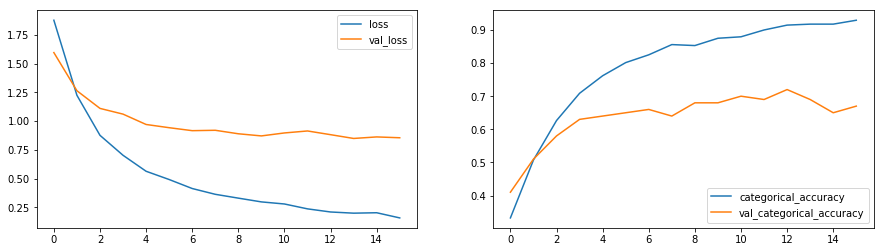

In [11]:
plot(history_model4)

### Reducing resolution to 120x120 and changing learning rate

In [10]:

# write your model here
# Creting Conv3D

num_images_to_use=20
image_height=160
image_width=160

model5 = Sequential([
    Conv3D(16, (2,2,2), padding='same', input_shape=(num_images_to_use, image_height, image_width, 3)),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2)),
    
    Conv3D(32, (2,2,2), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)),
    
    Conv3D(64, (2,2,2), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)),
           
    Conv3D(128, (2,2,2), strides=(1,1,1), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)),
           
           
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.20),
    
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.20),
    
    Dense(5, activation='softmax')
])

In [11]:
batch=20
epoch=20

optimiser = optimizers.SGD(lr=0.001)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', cooldown=0, min_lr=0.00001)

mg = ModelGenerator(num_images_to_use=num_images_to_use, image_height=image_height, image_width=image_width, batch=batch)
mt = ModelTrainer('conv3d_5', mg, model5, optimiser, batch=batch, epochs=epoch)
mt.set_callbacks([LR])
mt.compile_model()

# training sequences = 663
# validation sequences = 100
# epochs = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 20, 160, 160, 16)  400       
_________________________________________________________________
activation_5 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 10, 80, 80, 32)    4128      
_________________________________________________________________
activation_6 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_

In [51]:
history_model5 = mt.train()

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 20
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 20
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 3s - loss: 1.9747 - categorical_accuracy: 0.2922

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


34/34 [==============================] - 56s 2s/step - loss: 1.9052 - categorical_accuracy: 0.2912 - val_loss: 1.7468 - val_categorical_accuracy: 0.3500

Epoch 00001: saving model to model_init_conv3d_5_2021-02-0707_40_24.676446/model-00001-1.90516-0.29118-1.74685-0.35000.h5
Epoch 2/20
34/34 [==============================] - 45s 1s/step - loss: 1.2889 - categorical_accuracy: 0.4691 - val_loss: 1.3547 - val_categorical_accuracy: 0.4300

Epoch 00002: saving model to model_init_conv3d_5_2021-02-0707_40_24.676446/model-00002-1.28889-0.46912-1.35469-0.43000.h5
Epoch 3/20
34/34 [==============================] - 50s 1s/step - loss: 0.9974 - categorical_accuracy: 0.6088 - val_loss: 1.2641 - val_categorical_accuracy: 0.5300

Epoch 00003: saving model to model_init_conv3d_5_2021-02-0707_40_24.676446/model-00003-0.99744-0.60882-1.26408-0.53000.h5
Epoch 4/20
34/34 [==============================] - 50s 1s/step - loss: 0.7867 - categorical_accuracy: 0.6882 - val_loss: 1.2609 - val_categorical_acc

### CNN & LSTM

In [21]:
num_images_to_use=20
image_height=160
image_width=160

model6 = Sequential([
    TimeDistributed(Conv2D(16, (2,2), padding='same', activation='relu'), input_shape=(num_images_to_use, image_height, image_width, 3)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),
    
    TimeDistributed(Conv2D(32, (2,2), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),
    
    TimeDistributed(Conv2D(64, (2,2), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),
           
    TimeDistributed(Conv2D(128, (2,2), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),
           
           
    TimeDistributed(Flatten()),
    
    GRU(256, activation='relu'),
    Dropout(0.20),
    
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.20),
    
    Dense(5, activation='softmax')
])

In [22]:
batch=20
epoch=20

optimiser = optimizers.SGD(lr=0.001)
# LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', cooldown=0, min_lr=0.00001)

mg = ModelGenerator(num_images_to_use=num_images_to_use, image_height=image_height, image_width=image_width, batch=batch)
mt = ModelTrainer('conv3d_6', mg, model6, optimiser, batch=batch, epochs=epoch)
# mt.set_callbacks([LR])
mt.compile_model()

# training sequences = 663
# validation sequences = 100
# epochs = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_34 (TimeDis (None, 20, 160, 160, 16)  208       
_________________________________________________________________
time_distributed_35 (TimeDis (None, 20, 160, 160, 16)  64        
_________________________________________________________________
time_distributed_36 (TimeDis (None, 20, 80, 80, 16)    0         
_________________________________________________________________
time_distributed_37 (TimeDis (None, 20, 80, 80, 32)    2080      
_________________________________________________________________
time_distributed_38 (TimeDis (None, 20, 80, 80, 32)    128       
_________________________________________________________________
time_distributed_39 (TimeDis (None, 20, 40, 40, 32)    0         
_________________________________________________________________
time_d

In [23]:
history_model6 = mt.train()

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 20
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = Epoch 1/20
20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 8s - loss: 1.9768 - categorical_accuracy: 0.2438 

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


34/34 [==============================] - 149s 4s/step - loss: 1.9175 - categorical_accuracy: 0.2485 - val_loss: 1.6240 - val_categorical_accuracy: 0.3400

Epoch 00001: saving model to model_init_conv3d_6_2021-02-0805_13_33.258966/model-00001-1.91750-0.24853-1.62400-0.34000.h5
Epoch 2/20
34/34 [==============================] - 54s 2s/step - loss: 1.4501 - categorical_accuracy: 0.4176 - val_loss: 1.4886 - val_categorical_accuracy: 0.3800

Epoch 00002: saving model to model_init_conv3d_6_2021-02-0805_13_33.258966/model-00002-1.45009-0.41765-1.48858-0.38000.h5
Epoch 3/20
34/34 [==============================] - 56s 2s/step - loss: 1.2724 - categorical_accuracy: 0.4750 - val_loss: 1.7583 - val_categorical_accuracy: 0.3300

Epoch 00003: saving model to model_init_conv3d_6_2021-02-0805_13_33.258966/model-00003-1.27242-0.47500-1.75827-0.33000.h5
Epoch 4/20
34/34 [==============================] - 54s 2s/step - loss: 1.1304 - categorical_accuracy: 0.5132 - val_loss: 1.2238 - val_categorical_ac

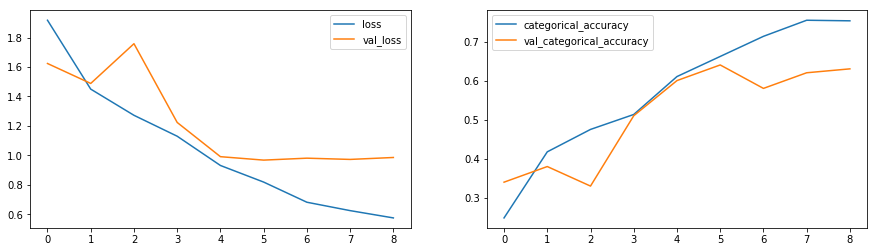

In [25]:
plot(history_model6)

### Transfer learning with GRU

In [9]:
from keras.applications import mobilenet

num_images_to_use=20
image_height=160
image_width=160

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

model7 = Sequential([
    TimeDistributed(mobilenet_transfer, input_shape=(num_images_to_use, image_height, image_width, 3)),
    
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),
           
           
    TimeDistributed(Flatten()),
    
    GRU(256, activation='relu'),
    Dropout(0.10),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.10),
    
    Dense(5, activation='softmax')
])

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:206: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


17227776/17225924 [==============================] - 1s 0us/step


In [10]:
batch=5
epoch=20

optimiser = optimizers.SGD(lr=0.001)
# LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', cooldown=0, min_lr=0.00001)

mg = ModelGenerator(num_images_to_use=num_images_to_use, image_height=image_height, image_width=image_width, batch=batch)
mt = ModelTrainer('conv3d_7', mg, model7, optimiser, batch=batch, epochs=epoch)
# mt.set_callbacks([LR])
mt.compile_model()

# training sequences = 663
# validation sequences = 100
# epochs = 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 20, 5, 5, 1024)    3228864   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 5, 5, 1024)    4096      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 4096)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               3343104   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_

In [11]:
history_model7 = mt.train()

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size =Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 5
 5
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


131/133 [============================>.] - ETA: 2s - loss: 1.7843 - categorical_accuracy: 0.2840

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


133/133 [==============================] - 203s 2s/step - loss: 1.7667 - categorical_accuracy: 0.2842 - val_loss: 1.7261 - val_categorical_accuracy: 0.3900

Epoch 00001: saving model to model_init_conv3d_7_2021-02-0816_51_08.597712/model-00001-1.76673-0.28421-1.72606-0.39000.h5
Epoch 2/20
133/133 [==============================] - 105s 786ms/step - loss: 1.2455 - categorical_accuracy: 0.4617 - val_loss: 0.9918 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to model_init_conv3d_7_2021-02-0816_51_08.597712/model-00002-1.24546-0.46165-0.99183-0.60000.h5
Epoch 3/20
133/133 [==============================] - 100s 750ms/step - loss: 0.9875 - categorical_accuracy: 0.5880 - val_loss: 0.8619 - val_categorical_accuracy: 0.5700

Epoch 00003: saving model to model_init_conv3d_7_2021-02-0816_51_08.597712/model-00003-0.98748-0.58797-0.86188-0.57000.h5
Epoch 4/20
133/133 [==============================] - 99s 742ms/step - loss: 0.6745 - categorical_accuracy: 0.7263 - val_loss: 0.5831 -

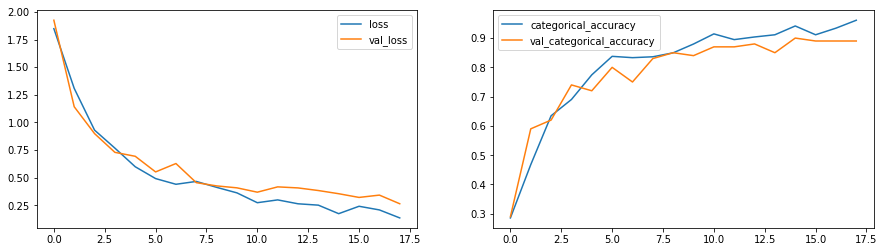

In [40]:
plot(history_model7)

In [22]:
import time
from keras.models import load_model
model = load_model('model-00013-0.21743-0.91579-0.27847-0.89000.h5')

In [23]:
mg = ModelGenerator(num_images_to_use=num_images_to_use, image_height=image_height, image_width=image_width, batch=batch)

In [24]:
train_gen, val_gen = mg.generate()

In [28]:
data, label = next(train_gen)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [29]:
label

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]])

In [30]:
print(np.argmax(model.predict(data[:,:,:,:,:]),axis=1))

[3 2 1 3 2]
